In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as ss
import itertools
import tensorflow as tf
import collections
import time
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, plot_roc_curve, roc_auc_score, accuracy_score, roc_curve, auc, f1_score, confusion_matrix, recall_score, plot_confusion_matrix, precision_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.neural_network import MLPClassifier
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, GRU, Embedding, Dropout, Activation, Bidirectional, GlobalMaxPool1D
from keras.models import Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras import callbacks
from keras.preprocessing import text, sequence
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

In [3]:
playList_no_dups= pd.read_pickle("PlayList_No_Dups.plk")
playList_no_dups

,PlayerKey,GameID,PlayKey,RosterPosition,PlayerDay,PlayerGame,StadiumType,FieldType,Temperature,Weather,PlayType,PlayerGamePlay,Position,PositionGroup
0,26624,26624-1,26624-1-1,Quarterback,1,1,Outdoor,Synthetic,63,Clear,Pass,1,QB,QB
81,26624,26624-2,26624-2-1,Quarterback,11,2,Indoor,Synthetic,85,Cloudy,Pass,1,QB,QB
157,26624,26624-3,26624-3-1,Quarterback,18,3,Outdoor,Synthetic,84,Clear,Rush,1,QB,QB
221,26624,26624-4,26624-4-1,Quarterback,25,4,Outdoor,Synthetic,61,Clear,Pass,1,QB,QB
291,26624,26624-5,26624-5-1,Quarterback,29,5,Outdoor,Natural,76,Clear,Pass,1,QB,QB
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266741,47888,47888-9,47888-9-1,Cornerback,71,9,Outdoor,Synthetic,53,Cloudy,Pass,1,DB,DB
266795,47888,47888-10,47888-10-1,Cornerback,78,10,Outdoor,Natural,82,Cloudy,Rush,1,DB,DB
266833,47888,47888-11,47888-11-1,Cornerback,85,11,Outdoor,Natural,42,Cloudy,Pass,1,DB,DB
266889,47888,47888-12,47888-12-1,Cornerback,92,12,Outdoor,Synthetic,40,Clear,Rush,1,DB,DB


In [4]:
injury_rec_df = pd.read_pickle("Injury.plk")
injury_rec_df

,PlayerKey,GameID,PlayKey,BodyPart,DM_M1,DM_M7,DM_M28,DM_M42
0,39873,39873-4,39873-4-32,Knee,1,1,1,1
1,46074,46074-7,46074-7-26,Knee,1,1,0,0
2,36557,36557-1,36557-1-70,Ankle,1,1,1,1
3,46646,46646-3,46646-3-30,Ankle,1,0,0,0
4,43532,43532-5,43532-5-69,Ankle,1,1,1,1
...,...,...,...,...,...,...,...,...
100,44423,44423-13,NaN,Knee,1,0,0,0
101,31933,31933-20,NaN,Knee,1,0,0,0
102,47285,47285-4,NaN,Knee,1,1,0,0
103,37068,37068-19,NaN,Knee,1,1,0,0


In [5]:
INJURY_VARS = ['DM_M1', 'DM_M7', 'DM_M28', 'DM_M42']

def fill_in_missing_values(df, array, value):
    for var in array:
        df[var] = df[var].fillna(value).astype(int)    
        
        
def normalize_variable_values(df, field, threshold):
    collection = []
    for i in range(len(df[field])):
        if(df[field][i]>threshold):
            collection.append(1)
        else:
            collection.append(0)
    df[field]=collection 

In [6]:
#merge injury and playList
games_injuries_df = injury_rec_df.set_index('GameID').join(playList_no_dups.set_index('GameID'), how = 'outer',lsuffix='_left', rsuffix='_right')
fill_in_missing_values(games_injuries_df, INJURY_VARS, 0)
games_injuries_df['Injury'] = games_injuries_df['DM_M1'] + games_injuries_df['DM_M7'] + games_injuries_df['DM_M28'] + games_injuries_df['DM_M42']
games_injuries_df

,PlayerKey_left,PlayKey_left,BodyPart,DM_M1,DM_M7,DM_M28,DM_M42,PlayerKey_right,PlayKey_right,RosterPosition,...,PlayerGame,StadiumType,FieldType,Temperature,Weather,PlayType,PlayerGamePlay,Position,PositionGroup,Injury
GameID,,,,,,,,,,,,,,,,,,,,,
26624-1,NaN,NaN,NaN,0,0,0,0,26624,26624-1-1,Quarterback,...,1,Outdoor,Synthetic,63,Clear,Pass,1,QB,QB,0
26624-10,NaN,NaN,NaN,0,0,0,0,26624,26624-10-1,Quarterback,...,10,Outdoor,Natural,66,Clear,Rush,1,QB,QB,0
26624-11,NaN,NaN,NaN,0,0,0,0,26624,26624-11-1,Quarterback,...,11,Outdoor,Synthetic,47,Cloudy,Pass,1,QB,QB,0
26624-12,NaN,NaN,NaN,0,0,0,0,26624,26624-12-1,Quarterback,...,12,Outdoor,Synthetic,48,Cloudy,Rush,1,QB,QB,0
26624-13,NaN,NaN,NaN,0,0,0,0,26624,26624-13-1,Quarterback,...,13,Outdoor,Natural,55,Clear,Rush,1,QB,QB,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47888-5,NaN,NaN,NaN,0,0,0,0,47888,47888-5-1,Cornerback,...,5,Outdoor,Synthetic,46,Cloudy,Punt Not Returned,1,DB,DB,0
47888-6,NaN,NaN,NaN,0,0,0,0,47888,47888-6-1,Cornerback,...,6,Outdoor,Synthetic,40,Clear,Kickoff Returned,1,DB,DB,0
47888-7,NaN,NaN,NaN,0,0,0,0,47888,47888-7-1,Cornerback,...,7,Outdoor,Natural,46,Clear,Rush,1,DB,DB,0


In [7]:
games_injuries_df.loc[(games_injuries_df['Injury'] > 0),'Injury'].count()

105

In [8]:
def split_set_on_target_variable(df, field):
    df_0= df[df[field]==0][:int(len(df)*1)]
    df_1 = df[df[field]==1]
    frames = [df_0, df_1]
    with_target = pd.concat(frames)
    return pd.get_dummies(with_target, dummy_na = False)

In [9]:
normalize_variable_values(games_injuries_df, 'Injury', 0)
games_injuries_df.drop(columns=['PlayerKey_left','BodyPart', 'PlayKey_right','PlayKey_left', 'PlayerKey_right', 'DM_M1', 'DM_M7', 'DM_M28', 'DM_M42', 'PlayerGamePlay'],axis=1,inplace=True)
games_injuries_with_target = split_set_on_target_variable(games_injuries_df, 'Injury')
games_injuries_with_target 

,PlayerDay,PlayerGame,Temperature,Injury,RosterPosition_Cornerback,RosterPosition_Defensive Lineman,RosterPosition_Kicker,RosterPosition_Linebacker,RosterPosition_Offensive Lineman,RosterPosition_Quarterback,...,Position_WR,PositionGroup_DB,PositionGroup_DL,PositionGroup_LB,PositionGroup_OL,PositionGroup_QB,PositionGroup_RB,PositionGroup_SPEC,PositionGroup_TE,PositionGroup_WR
GameID,,,,,,,,,,,,,,,,,,,,,
26624-1,1,1,63,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
26624-10,74,10,66,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
26624-11,81,11,47,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
26624-12,88,12,48,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
26624-13,96,13,55,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47307-10,74,10,68,1,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
47307-10,74,10,68,1,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
47334-8,58,8,74,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [10]:
games_injuries_with_target.columns

Index(['PlayerDay', 'PlayerGame', 'Temperature', 'Injury',
       'RosterPosition_Cornerback', 'RosterPosition_Defensive Lineman',
       'RosterPosition_Kicker', 'RosterPosition_Linebacker',
       'RosterPosition_Offensive Lineman', 'RosterPosition_Quarterback',
       'RosterPosition_Running Back', 'RosterPosition_Safety',
       'RosterPosition_Tight End', 'RosterPosition_Wide Receiver',
       'StadiumType_Dome', 'StadiumType_Indoor', 'StadiumType_Outdoor',
       'StadiumType_Retractable Roof', 'FieldType_Natural',
       'FieldType_Synthetic', 'Weather_Clear', 'Weather_Cloudy',
       'Weather_Indoor', 'Weather_Rainy', 'Weather_Snowy', 'PlayType_0',
       'PlayType_Extra Point', 'PlayType_Field Goal', 'PlayType_Kickoff',
       'PlayType_Kickoff Not Returned', 'PlayType_Kickoff Returned',
       'PlayType_Pass', 'PlayType_Punt', 'PlayType_Punt Not Returned',
       'PlayType_Punt Returned', 'PlayType_Rush', 'Position_C', 'Position_CB',
       'Position_DB', 'Position_DE', 'Posi

In [11]:
#get rid off unnecessary vars
games_injuries_with_target.drop(['RosterPosition_Cornerback','StadiumType_Dome','FieldType_Natural',
                                 'Weather_Clear',
                                 'PlayType_0',
                                 'Position_C',
                                 'PositionGroup_DB'], axis=1, inplace=True)

games_injuries_with_target = games_injuries_with_target.reset_index(level=0)
games_injuries_with_target

,GameID,PlayerDay,PlayerGame,Temperature,Injury,RosterPosition_Defensive Lineman,RosterPosition_Kicker,RosterPosition_Linebacker,RosterPosition_Offensive Lineman,RosterPosition_Quarterback,...,Position_TE,Position_WR,PositionGroup_DL,PositionGroup_LB,PositionGroup_OL,PositionGroup_QB,PositionGroup_RB,PositionGroup_SPEC,PositionGroup_TE,PositionGroup_WR
0,26624-1,1,1,63,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
1,26624-10,74,10,66,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
2,26624-11,81,11,47,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
3,26624-12,88,12,48,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
4,26624-13,96,13,55,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5708,47307-10,74,10,68,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5709,47307-10,74,10,68,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5710,47334-8,58,8,74,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5711,47382-3,18,3,61,1,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0


In [12]:
#changing the playdate values
games_injuries_with_target["PlayerDay"] = games_injuries_with_target["PlayerDay"].abs()
features_df= games_injuries_with_target.set_index('GameID')
features_df

,PlayerDay,PlayerGame,Temperature,Injury,RosterPosition_Defensive Lineman,RosterPosition_Kicker,RosterPosition_Linebacker,RosterPosition_Offensive Lineman,RosterPosition_Quarterback,RosterPosition_Running Back,...,Position_TE,Position_WR,PositionGroup_DL,PositionGroup_LB,PositionGroup_OL,PositionGroup_QB,PositionGroup_RB,PositionGroup_SPEC,PositionGroup_TE,PositionGroup_WR
GameID,,,,,,,,,,,,,,,,,,,,,
26624-1,1,1,63,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
26624-10,74,10,66,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
26624-11,81,11,47,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
26624-12,88,12,48,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
26624-13,96,13,55,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47307-10,74,10,68,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
47307-10,74,10,68,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
47334-8,58,8,74,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
features_df.columns

Index(['PlayerDay', 'PlayerGame', 'Temperature', 'Injury',
       'RosterPosition_Defensive Lineman', 'RosterPosition_Kicker',
       'RosterPosition_Linebacker', 'RosterPosition_Offensive Lineman',
       'RosterPosition_Quarterback', 'RosterPosition_Running Back',
       'RosterPosition_Safety', 'RosterPosition_Tight End',
       'RosterPosition_Wide Receiver', 'StadiumType_Indoor',
       'StadiumType_Outdoor', 'StadiumType_Retractable Roof',
       'FieldType_Synthetic', 'Weather_Cloudy', 'Weather_Indoor',
       'Weather_Rainy', 'Weather_Snowy', 'PlayType_Extra Point',
       'PlayType_Field Goal', 'PlayType_Kickoff',
       'PlayType_Kickoff Not Returned', 'PlayType_Kickoff Returned',
       'PlayType_Pass', 'PlayType_Punt', 'PlayType_Punt Not Returned',
       'PlayType_Punt Returned', 'PlayType_Rush', 'Position_CB', 'Position_DB',
       'Position_DE', 'Position_DT', 'Position_FS', 'Position_G',
       'Position_HB', 'Position_ILB', 'Position_K', 'Position_LB',
       'Position

In [14]:
features_df.describe()

,PlayerDay,PlayerGame,Temperature,Injury,RosterPosition_Defensive Lineman,RosterPosition_Kicker,RosterPosition_Linebacker,RosterPosition_Offensive Lineman,RosterPosition_Quarterback,RosterPosition_Running Back,...,Position_TE,Position_WR,PositionGroup_DL,PositionGroup_LB,PositionGroup_OL,PositionGroup_QB,PositionGroup_RB,PositionGroup_SPEC,PositionGroup_TE,PositionGroup_WR
count,5713.000000,5713.000000,5713.000000,5713.000000,5713.000000,5713.000000,5713.000000,5713.000000,5713.000000,5713.000000,...,5713.000000,5713.000000,5713.000000,5713.000000,5713.000000,5713.000000,5713.000000,5713.000000,5713.000000,5713.000000
mean,209.787677,13.433398,60.884999,0.018379,0.126203,0.012078,0.192718,0.143532,0.019254,0.069316,...,0.033958,0.165937,0.124278,0.194819,0.143532,0.019254,0.069316,0.012078,0.033958,0.165762
std,182.417359,8.336088,16.647353,0.134330,0.332108,0.109243,0.394468,0.350646,0.137430,0.254012,...,0.181136,0.372057,0.329927,0.396096,0.350646,0.137430,0.254012,0.109243,0.181136,0.371900
min,1.000000,1.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,43.000000,6.000000,49.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,99.000000,13.000000,61.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,400.000000,20.000000,72.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,480.000000,32.000000,97.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [15]:
sr = features_df['Injury']
injured = sr[sr == 1].count()
non_injured = sr[sr == 0].count()
print("injury:" + str(injured) + ", no injury:" + str(non_injured))

injury:105, no injury:5608


In [16]:
oversampling = RandomOverSampler(random_state=0,sampling_strategy=0.25)
target = features_df['Injury']
descriptive = features_df.drop(columns=['Injury'])
X_oversampled, Y_oversampled = oversampling.fit_resample(descriptive, target)
y_oversampled = pd.DataFrame(Y_oversampled)
y_oversampled.columns = ['Target']
print("Number of desrcriptive features:" + str(len(descriptive.columns)))
print("Target feature ratio: \n" + str(y_oversampled['Target'].value_counts()))

Number of desrcriptive features:59
Target feature ratio: 
0    5608
1    1402
Name: Target, dtype: int64


In [17]:
X_oversampled

,PlayerDay,PlayerGame,Temperature,RosterPosition_Defensive Lineman,RosterPosition_Kicker,RosterPosition_Linebacker,RosterPosition_Offensive Lineman,RosterPosition_Quarterback,RosterPosition_Running Back,RosterPosition_Safety,...,Position_TE,Position_WR,PositionGroup_DL,PositionGroup_LB,PositionGroup_OL,PositionGroup_QB,PositionGroup_RB,PositionGroup_SPEC,PositionGroup_TE,PositionGroup_WR
0,1,1,63,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
1,74,10,66,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
2,81,11,47,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,88,12,48,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
4,96,13,55,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7005,43,6,75,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
7006,379,14,78,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
7007,22,4,71,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
7008,396,15,70,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1


In [18]:
y_oversampled

,Target
0,0
1,0
2,0
3,0
4,0
...,...
7005,1
7006,1
7007,1
7008,1


In [112]:
#prepare train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_oversampled, Y_oversampled, test_size=0.2, random_state=42,shuffle=True)    

In [72]:
collections.Counter(y_test)

Counter({1: 279, 0: 1123})

In [73]:
training_times = {}
predicting_times = {}
roc_scores = {}
accuracy_scores = {}
f1_scores = {}
MODEL_CODES = {'Naive Bayes' : 'NB', 'Logistic Regression': 'LR', 'Decision Tree Classifier': 'DTC', 'XGB Classifier': 'XGB', 'Multi-Layer Perceptron' : 'MLP', 'Random Forest': 'RF', 'K-Neighbors Classifier' : 'KNN', 'LSTM': 'LSTM', 'GRU': 'GRU'}

In [23]:
def plot_conf_matrix(y_test, y_pred, name, classes = None , figsize = (6, 6) , text_size = 12):
    # Setting the default figsize 
    figsize = figsize
    # Create the confusion matrix from sklearn 
    cm = confusion_matrix(y_test , tf.math.round(y_pred))
    cm_norm = cm.astype('float') / cm.sum(axis = 1)[: , np.newaxis] # Normalize our confusion matrix 
    # Number of clases
    n_classes = cm.shape[0]
    # Making our plot pretty
    fig , ax = plt.subplots(figsize = figsize)
    # Drawing the matrix plot 
    cax = ax.matshow(cm , cmap = plt.cm.Blues)
    fig.colorbar(cax)

    # Set labels to be classes
    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])

    # Label axes
    ax.set(title ='Confusion Matrix ' + name , 
       xlabel = 'Predicted Label' , 
       ylabel = 'True Label' , 
       xticks = np.arange(n_classes) , 
       yticks = np.arange(n_classes) , 
       xticklabels = labels , 
       yticklabels = labels)
    # Set the xaxis labels to bottom 
    ax.xaxis.set_label_position('bottom')
    ax.xaxis.tick_bottom()

    # Adjust the label size 
    ax.yaxis.label.set_size(text_size)
    ax.xaxis.label.set_size(text_size)
    ax.title.set_size(text_size)

    # Set threshold for different colors 
    threshold = (cm.max() + cm.min()) / 2

    # Plot the text on each cell 
    for i , j in itertools.product(range(cm.shape[0]) , range(cm.shape[1])):
        plt.text(j , i , f'{cm[i , j]} ({cm_norm[i , j]*100:.1f}%)' , 
               horizontalalignment = 'center' , 
                color = 'white' if cm[i , j] > threshold else 'black' , 
               size = text_size)

In [63]:
def plot_roc(Y_test, y_pred, name, figsize=(6, 6)):
    fpr, tpr, _ = roc_curve(Y_test, y_pred)
    auc_value = round(auc(fpr, tpr), 2)
    plt.figure(figsize=figsize)
    plt.plot([0,1], [0,1], 'b--')
    plt.plot(fpr, tpr, 'r-')
    plt.title('ROC curve for {}'.format(name))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(['_nolegend_', '{} AUC= {}'.format(name, auc_value)], loc='lower right')
    plt.show();

In [64]:
def plot_performance_results(name, y_pred, y_test, train_time, pred_time, flatten= False):
    if flatten:
        p_pred = y_pred.flatten()
        y_pred = np.where(p_pred > 0.5, 1, 0)
    
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    training_times[name] = train_time
    predicting_times[name] = pred_time
    roc_scores[name] = roc_auc_score(y_test, y_pred)
    accuracy_scores[name] = acc
    f1_scores[name] = f1
    print(name)
    print('Training time: {} secs'.format(train_time))
    print('Prediction time: {} secs'.format(pred_time))
    print('Accuracy: {}'.format(acc))
    print('F1-score: {}'.format(f1))
    plot_conf_matrix(y_test, y_pred, name)
    plot_roc(y_test, y_pred, name)

In [26]:
def train(model, X_train ,y_train):
    start = time.time()
    model.fit(X_train ,y_train)
    end = time.time()
    return end-start

In [27]:
def test(model, X_test):
    start = time.time()
    y_pred = model.predict(X_test)
    end = time.time()
    return y_pred, end-start 

In [28]:
def plot_bar_graph(dictionary, title_text, y_title):
    keys = dictionary.keys()
    key_codes = []
    for key in keys:
        key_codes.append(MODEL_CODES[key])   
    values = dictionary.values()
    plt.figure(figsize=(6,6))
    plt.bar(key_codes, values, color='#EE2C2C', align='center')
    plt.xticks(rotation=90)
    plt.title(title_text)
    plt.ylabel(y_title)
    #plt.xlabel('Models')
    plt.tight_layout()
    plt.show()

In [29]:
def plot_important_vars(model, x_train, num):    
    if not hasattr(model, 'feature_importances_'):
        print('model has no attribute feature_importances_!')
        return    
    #plot most important variables
    importances = model.feature_importances_
    sorted_indices = np.argsort(importances)[::-1]
    features = x_train.columns
    importances = model.feature_importances_
    indices = np.argsort(importances)
    #number of features to plot
    num_features = num 
    impdf= importances[indices[-num_features:]]
    indi = indices[-num_features:]
    plt.figure(figsize=(8,6))
    plt.bar(range(num_features), impdf[::-1], color="c", align='center')
    plt.xticks(range(num_features), [features[i] for i in indi[::-1]], rotation=90)
    plt.ylabel('Importance')
    plt.title('Variable Importances')
    plt.tight_layout()
    plt.show()

K-Neighbors Classifier
Training time: 0.005985260009765625 secs
Prediction time: 0.1723630428314209 secs
Accuracy: 0.978601997146933
F1-score: 0.9477351916376306


C:\Users\koutoua\AppData\Local\Temp\ipykernel_11744\3067768115.py:10: UserWarning: The handle <matplotlib.lines.Line2D object at 0x0000028A4C36D1C0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  plt.legend(['_nolegend_', '{} AUC= {}'.format(name, auc_value)], loc='lower right')


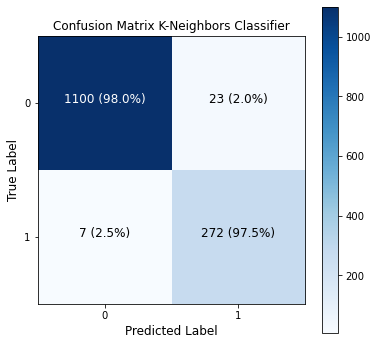

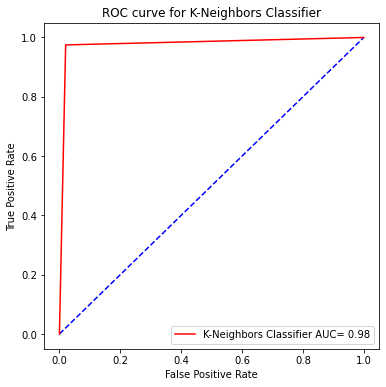

model has no attribute feature_importances_!


In [113]:
#KNN
knn_model = KNeighborsClassifier(n_neighbors=2)
train_time = train(knn_model, X_train ,y_train)
y_pred, pred_time = test(knn_model, X_test)
plot_performance_results("K-Neighbors Classifier", y_pred, y_test, train_time, pred_time)
plot_important_vars(knn_model, X_train, 10)

Naive Bayes
Training time: 0.009973526000976562 secs
Prediction time: 0.002991199493408203 secs
Accuracy: 0.30813124108416545
F1-score: 0.3651832460732984


C:\Users\koutoua\AppData\Local\Temp\ipykernel_11744\3067768115.py:10: UserWarning: The handle <matplotlib.lines.Line2D object at 0x0000028A4619E100> has a label of '_nolegend_' which cannot be automatically added to the legend.
  plt.legend(['_nolegend_', '{} AUC= {}'.format(name, auc_value)], loc='lower right')


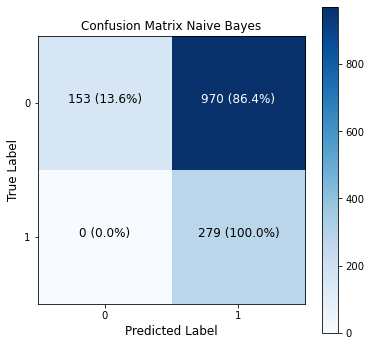

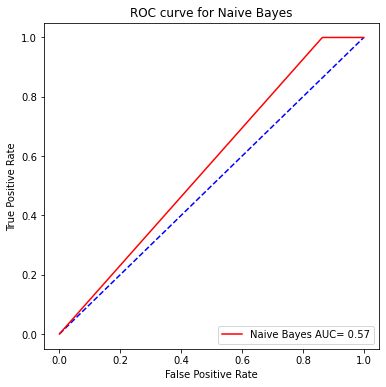

model has no attribute feature_importances_!


In [114]:
#Gaussian Naive Bayes 
nb_model = GaussianNB()
train_time = train(nb_model, X_train ,y_train)
y_pred, pred_time = test(nb_model, X_test)
plot_performance_results("Naive Bayes", y_pred, y_test, train_time, pred_time)
plot_important_vars(nb_model, X_train, 10)

Logistic Regression
Training time: 0.48057055473327637 secs
Prediction time: 0.0029921531677246094 secs
Accuracy: 0.7931526390870185
F1-score: 0.03973509933774835


C:\Users\koutoua\AppData\Local\Temp\ipykernel_11744\3067768115.py:10: UserWarning: The handle <matplotlib.lines.Line2D object at 0x0000028A4075B190> has a label of '_nolegend_' which cannot be automatically added to the legend.
  plt.legend(['_nolegend_', '{} AUC= {}'.format(name, auc_value)], loc='lower right')


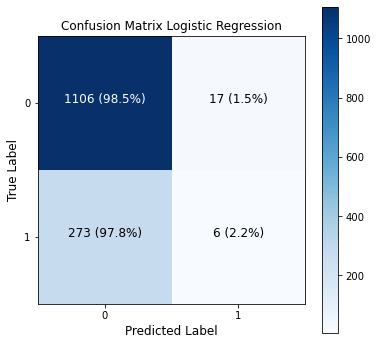

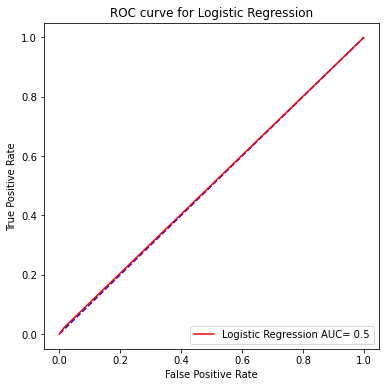

model has no attribute feature_importances_!


In [115]:
#Logistic Regression 
lr_model = LogisticRegression(max_iter=5000)
train_time = train(lr_model, X_train ,y_train)
y_pred, pred_time = test(lr_model, X_test)
plot_performance_results("Logistic Regression", y_pred, y_test, train_time, pred_time)
plot_important_vars(lr_model, X_train, 10)

Decision Tree Classifier
Training time: 0.04811239242553711 secs
Prediction time: 0.002995729446411133 secs
Accuracy: 0.9671897289586305
F1-score: 0.923841059602649


C:\Users\koutoua\AppData\Local\Temp\ipykernel_11744\3067768115.py:10: UserWarning: The handle <matplotlib.lines.Line2D object at 0x0000028A425AD910> has a label of '_nolegend_' which cannot be automatically added to the legend.
  plt.legend(['_nolegend_', '{} AUC= {}'.format(name, auc_value)], loc='lower right')


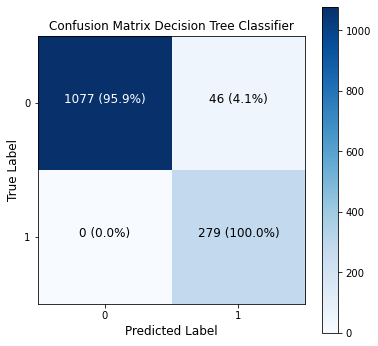

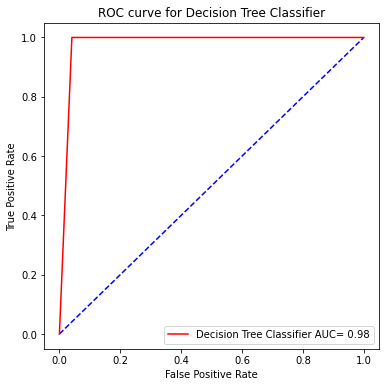

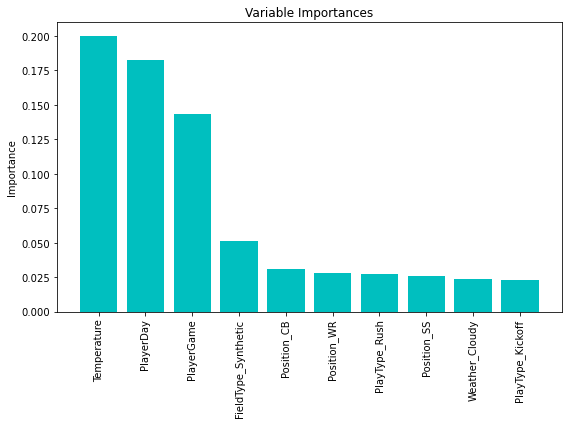

In [116]:
#Decision Trees Classifier
dtc_model = DecisionTreeClassifier(max_depth=16)
train_time = train(dtc_model, X_train ,y_train)
y_pred, pred_time = test(dtc_model, X_test)
plot_performance_results("Decision Tree Classifier", y_pred, y_test, train_time, pred_time)
plot_important_vars(dtc_model, X_train, 10)

C:\Users\koutoua\Anaconda3\envs\tensorflow_env\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\koutoua\Anaconda3\envs\tensorflow_env\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[19:25:29] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGB Classifier
Training time: 1.2012171745300293 secs
Prediction time: 0.006131887435913086 secs
Accuracy: 0.9814550641940085
F1-score: 0.9545454545454546


C:\Users\koutoua\AppData\Local\Temp\ipykernel_11744\3067768115.py:10: UserWarning: The handle <matplotlib.lines.Line2D object at 0x0000028A39E09160> has a label of '_nolegend_' which cannot be automatically added to the legend.
  plt.legend(['_nolegend_', '{} AUC= {}'.format(name, auc_value)], loc='lower right')


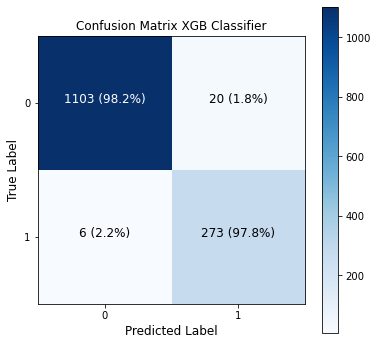

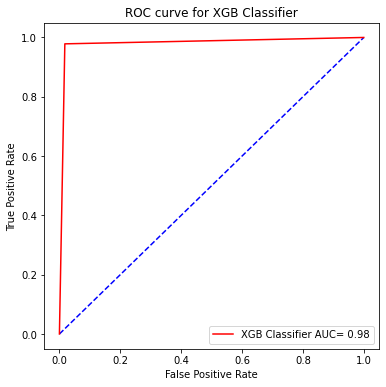

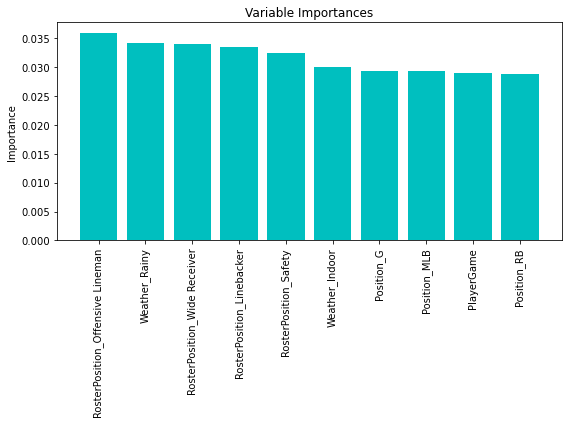

In [117]:
#XGBoost 
xgb_model = xgb.XGBClassifier(max_depth=4,
                      learning_rate=0.1,
                      n_estimators=450,
                      objective='binary:logistic',
                      booster='gbtree',
                      tree_method='auto',
                      n_jobs=50,
                      gamma=0,
                      min_child_weight=1,
                      max_delta_step=0,
                      subsample=1,
                      colsample_bytree=1,
                      colsample_bylevel=1,
                      colsample_bynode=1,
                      reg_alpha=0,
                      reg_lambda=1,
                      scale_pos_weight=1,
                      base_score=0.5,
                      random_state=0)

train_time = train(xgb_model, X_train ,y_train)
y_pred, pred_time = test(xgb_model, X_test)
plot_performance_results("XGB Classifier", y_pred, y_test, train_time, pred_time)
plot_important_vars(xgb_model, X_train, 10)

Multi-Layer Perceptron
Training time: 4.5031208992004395 secs
Prediction time: 0.003231525421142578 secs
Accuracy: 0.8238231098430813
F1-score: 0.6602475928473177


C:\Users\koutoua\Anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\koutoua\AppData\Local\Temp\ipykernel_11744\3067768115.py:10: UserWarning: The handle <matplotlib.lines.Line2D object at 0x0000028A41BB7BE0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  plt.legend(['_nolegend_', '{} AUC= {}'.format(name, auc_value)], loc='lower right')


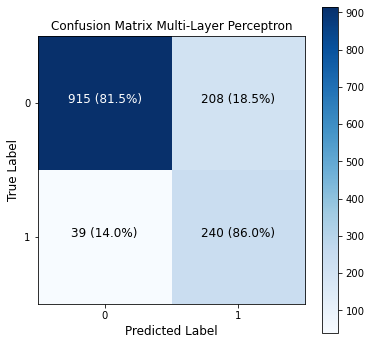

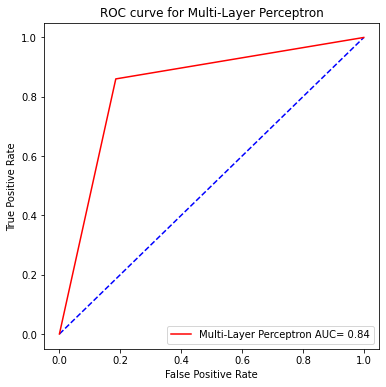

model has no attribute feature_importances_!


In [118]:
#Multi-Layer Perceptron
mlp_model =  MLPClassifier(random_state=5)
train_time = train(mlp_model, X_train ,y_train)
y_pred, pred_time = test(mlp_model, X_test)
plot_performance_results("Multi-Layer Perceptron", y_pred, y_test, train_time, pred_time)
plot_important_vars(mlp_model, X_train, 10)

Random Forest
Training time: 0.28008460998535156 secs
Prediction time: 0.034132957458496094 secs
Accuracy: 0.9950071326676176
F1-score: 0.9876106194690266


C:\Users\koutoua\AppData\Local\Temp\ipykernel_11744\3067768115.py:10: UserWarning: The handle <matplotlib.lines.Line2D object at 0x0000028A42067550> has a label of '_nolegend_' which cannot be automatically added to the legend.
  plt.legend(['_nolegend_', '{} AUC= {}'.format(name, auc_value)], loc='lower right')


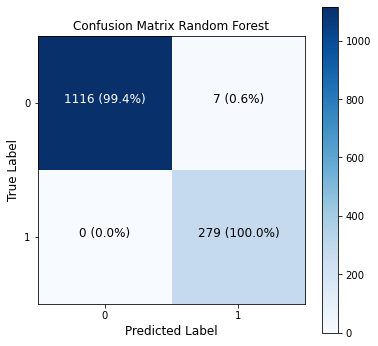

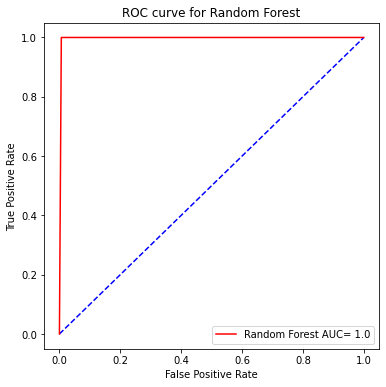

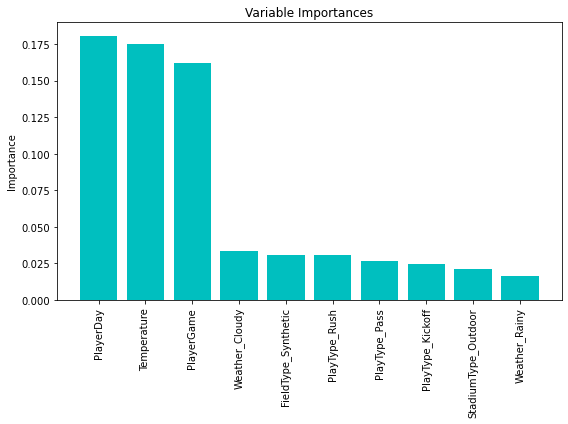

In [119]:
#Random Forest
rfc_model = RandomForestClassifier(n_estimators=128,
                                max_features='auto',
                                n_jobs = 8,
                                random_state = 42)
train_time = train(rfc_model, X_train ,y_train)
y_pred, pred_time = test(rfc_model, X_test)
plot_performance_results("Random Forest", y_pred, y_test, train_time, pred_time)
plot_important_vars(rfc_model, X_train, 10)

In [120]:
X_train, X_val_and_test, Y_train, Y_val_and_test = train_test_split(X_oversampled, Y_oversampled, test_size=0.3, random_state=21, shuffle=True)
X_val, X_test, Y_val, Y_test = train_test_split(X_val_and_test, Y_val_and_test, test_size=0.5)

In [121]:
#LSTM ANN
checkpoint = callbacks.ModelCheckpoint('lstm_model_s1.h5', 
                                       save_best_only=True)
embedding_size = 128
input_emb = 20000
model_lstm = tf.keras.models.Sequential()
model_lstm.add(tf.keras.layers.Embedding(input_emb, embedding_size, 
                                    input_shape=(59,)))
model_lstm.add(tf.keras.layers.LSTM(29, return_sequences=True))
model_lstm.add(tf.keras.layers.LSTM(29, return_sequences=True))
model_lstm.add(tf.keras.layers.GlobalMaxPool1D())
model_lstm.add(tf.keras.layers.Dropout(0.2))
model_lstm.add(tf.keras.layers.Dense(29, activation='relu'))
model_lstm.add(tf.keras.layers.Dropout(0.2))
model_lstm.add(tf.keras.layers.Dense(29, activation='relu'))
model_lstm.add(tf.keras.layers.Dropout(0.2))
model_lstm.add(tf.keras.layers.Dense(29, activation='relu'))
model_lstm.add(tf.keras.layers.Dropout(0.2))
model_lstm.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_lstm.compile(loss='binary_crossentropy',
              optimizer='adam', 
              metrics=['accuracy'])

start_lstm_train = time.time()

history = model_lstm.fit(X_train, Y_train,
                    epochs=120, 
                    batch_size=128, 
                    validation_data=(X_val, Y_val),
                    callbacks=[checkpoint])

end_lstm_train = time.time()
lstm_train_time = end_lstm_train - start_lstm_train

Epoch 1/120
39/39 [==============================] - 10s 128ms/step - loss: 0.5859 - accuracy: 0.7815 - val_loss: 0.4727 - val_accuracy: 0.8211
Epoch 2/120
39/39 [==============================] - 4s 96ms/step - loss: 0.5210 - accuracy: 0.7956 - val_loss: 0.4486 - val_accuracy: 0.8211
Epoch 3/120
39/39 [==============================] - 4s 100ms/step - loss: 0.4348 - accuracy: 0.7956 - val_loss: 0.3814 - val_accuracy: 0.8211
Epoch 4/120
39/39 [==============================] - 4s 99ms/step - loss: 0.3747 - accuracy: 0.7956 - val_loss: 0.3668 - val_accuracy: 0.8211
Epoch 5/120
39/39 [==============================] - 4s 103ms/step - loss: 0.3410 - accuracy: 0.7956 - val_loss: 0.3686 - val_accuracy: 0.8211
Epoch 6/120
39/39 [==============================] - 4s 99ms/step - loss: 0.3367 - accuracy: 0.7956 - val_loss: 0.3533 - val_accuracy: 0.8211
Epoch 7/120
39/39 [==============================] - 4s 100ms/step - loss: 0.3205 - accuracy: 0.7997 - val_loss: 0.3623 - val_accuracy: 0.8268
E

In [122]:
# get the best model from validation
model_lstm = tf.keras.models.load_model('lstm_model_s1.h5')
start_lstm_pred = time.time()
y_pred = model_lstm.predict(X_test)
end_lstm_pred = time.time()
lstm_pred_time = end_lstm_pred - start_lstm_pred

In [123]:
model_lstm.evaluate(X_test, Y_test)[1]

33/33 [==============================] - 2s 18ms/step - loss: 0.1307 - accuracy: 0.9401


0.9401140809059143

LSTM
Training time: 520.7233307361603 secs
Prediction time: 3.033051013946533 secs
Accuracy: 0.9401140684410646
F1-score: 0.8633405639913231


C:\Users\koutoua\AppData\Local\Temp\ipykernel_11744\3067768115.py:10: UserWarning: The handle <matplotlib.lines.Line2D object at 0x0000028A38A44AC0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  plt.legend(['_nolegend_', '{} AUC= {}'.format(name, auc_value)], loc='lower right')


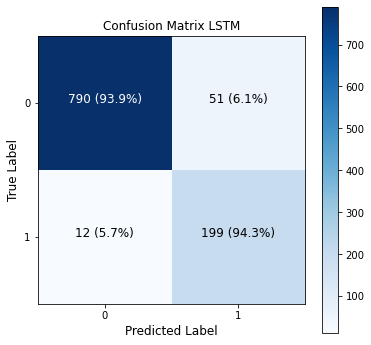

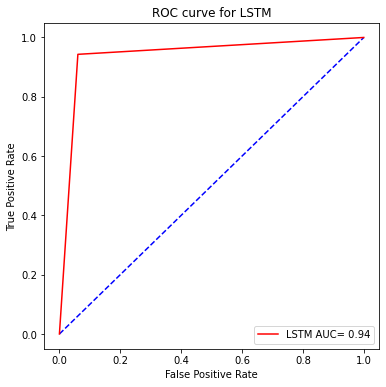

model has no attribute feature_importances_!


In [124]:
plot_performance_results("LSTM", y_pred, Y_test, lstm_train_time, lstm_pred_time, flatten=True)
plot_important_vars(model_lstm, X_train, 10)

In [125]:
#GRU ANN
checkpoint = callbacks.ModelCheckpoint('gru_model_s1.h5', 
                                       save_best_only=True)
embedding_size = 128
input_emb = 20000
model_gru = tf.keras.models.Sequential()
model_gru.add(tf.keras.layers.Embedding(input_emb, embedding_size, input_shape=(59,)))
model_gru.add(tf.keras.layers.GRU(30, return_sequences=True, input_shape=(59,)))
model_gru.add(tf.keras.layers.GRU(30, return_sequences=True, input_shape=(59,)))
model_gru.add(tf.keras.layers.GlobalMaxPool1D())
model_gru.add(tf.keras.layers.Dropout(0.2))
model_gru.add(tf.keras.layers.Dense(30, activation='relu'))
model_gru.add(tf.keras.layers.Dropout(0.2))
model_gru.add(tf.keras.layers.Dense(30, activation='relu'))
model_gru.add(tf.keras.layers.Dropout(0.2))
model_gru.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_gru.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

start_gru_train = time.time()

history = model_gru.fit(X_train, Y_train, 
                    epochs=120, batch_size=128, 
                    validation_data=(X_val, Y_val),
                    callbacks=[checkpoint])

end_gru_train = time.time()
gru_train_time = end_gru_train - start_gru_train

Epoch 1/120
39/39 [==============================] - 16s 181ms/step - loss: 0.5756 - accuracy: 0.7783 - val_loss: 0.4684 - val_accuracy: 0.8211
Epoch 2/120
39/39 [==============================] - 6s 144ms/step - loss: 0.5083 - accuracy: 0.7954 - val_loss: 0.4468 - val_accuracy: 0.8211
Epoch 3/120
39/39 [==============================] - 5s 138ms/step - loss: 0.4322 - accuracy: 0.7952 - val_loss: 0.3822 - val_accuracy: 0.8211
Epoch 4/120
39/39 [==============================] - 5s 139ms/step - loss: 0.3795 - accuracy: 0.7954 - val_loss: 0.3514 - val_accuracy: 0.8221
Epoch 5/120
39/39 [==============================] - 6s 151ms/step - loss: 0.3586 - accuracy: 0.7985 - val_loss: 0.3339 - val_accuracy: 0.8069
Epoch 6/120
39/39 [==============================] - 6s 143ms/step - loss: 0.3408 - accuracy: 0.8027 - val_loss: 0.3283 - val_accuracy: 0.8164
Epoch 7/120
39/39 [==============================] - 6s 143ms/step - loss: 0.3233 - accuracy: 0.8093 - val_loss: 0.3012 - val_accuracy: 0.846

In [126]:
model_gru = tf.keras.models.load_model('gru_model_s1.h5')
start_gru_pred = time.time()
y_pred = model_gru.predict(X_test)
end_gru_pred = time.time()
gru_pred_time = end_gru_pred - start_gru_pred

In [127]:
model_gru.evaluate(X_test, Y_test)[1]

33/33 [==============================] - 3s 24ms/step - loss: 0.1327 - accuracy: 0.9515 0s - loss: 0.1358 - 


0.9515209197998047

GRU
Training time: 684.4242413043976 secs
Prediction time: 2.4411985874176025 secs
Accuracy: 0.9515209125475285
F1-score: 0.8917197452229298


C:\Users\koutoua\AppData\Local\Temp\ipykernel_11744\3067768115.py:10: UserWarning: The handle <matplotlib.lines.Line2D object at 0x0000028A42807940> has a label of '_nolegend_' which cannot be automatically added to the legend.
  plt.legend(['_nolegend_', '{} AUC= {}'.format(name, auc_value)], loc='lower right')


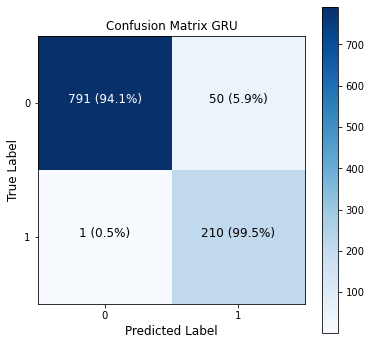

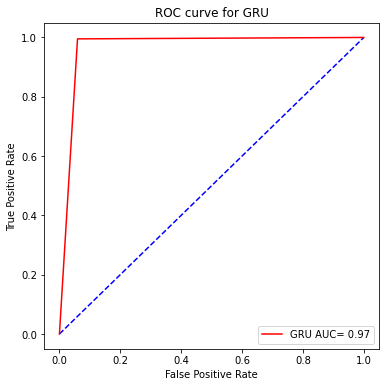

model has no attribute feature_importances_!


In [128]:
plot_performance_results("GRU", y_pred, Y_test, gru_train_time, gru_pred_time, flatten=True)
plot_important_vars(model_gru, X_train, 10)

In [129]:
training_times

{'K-Neighbors Classifier': 0.005985260009765625,
 'Naive Bayes': 0.009973526000976562,
 'Logistic Regression': 0.48057055473327637,
 'Decision Tree Classifier': 0.04811239242553711,
 'XGB Classifier': 1.2012171745300293,
 'Multi-Layer Perceptron': 4.5031208992004395,
 'Random Forest': 0.28008460998535156,
 'LSTM': 520.7233307361603,
 'GRU': 684.4242413043976}

In [130]:
predicting_times

{'K-Neighbors Classifier': 0.1723630428314209,
 'Naive Bayes': 0.002991199493408203,
 'Logistic Regression': 0.0029921531677246094,
 'Decision Tree Classifier': 0.002995729446411133,
 'XGB Classifier': 0.006131887435913086,
 'Multi-Layer Perceptron': 0.003231525421142578,
 'Random Forest': 0.034132957458496094,
 'LSTM': 3.033051013946533,
 'GRU': 2.4411985874176025}

In [131]:
roc_scores

{'K-Neighbors Classifier': 0.9772147697060803,
 'Naive Bayes': 0.5681211041852181,
 'Logistic Regression': 0.5031836765959077,
 'Decision Tree Classifier': 0.979519145146928,
 'XGB Classifier': 0.9803425923266214,
 'Multi-Layer Perceptron': 0.8374984440678291,
 'Random Forest': 0.9968833481745325,
 'LSTM': 0.941242934669289,
 'GRU': 0.9679038157012357}

In [132]:
accuracy_scores

{'K-Neighbors Classifier': 0.978601997146933,
 'Naive Bayes': 0.30813124108416545,
 'Logistic Regression': 0.7931526390870185,
 'Decision Tree Classifier': 0.9671897289586305,
 'XGB Classifier': 0.9814550641940085,
 'Multi-Layer Perceptron': 0.8238231098430813,
 'Random Forest': 0.9950071326676176,
 'LSTM': 0.9401140684410646,
 'GRU': 0.9515209125475285}

In [133]:
f1_scores

{'K-Neighbors Classifier': 0.9477351916376306,
 'Naive Bayes': 0.3651832460732984,
 'Logistic Regression': 0.03973509933774835,
 'Decision Tree Classifier': 0.923841059602649,
 'XGB Classifier': 0.9545454545454546,
 'Multi-Layer Perceptron': 0.6602475928473177,
 'Random Forest': 0.9876106194690266,
 'LSTM': 0.8633405639913231,
 'GRU': 0.8917197452229298}

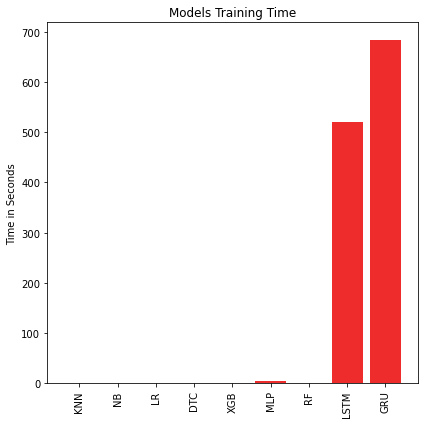

In [134]:
plot_bar_graph(training_times, "Models Training Time" , "Time in Seconds")

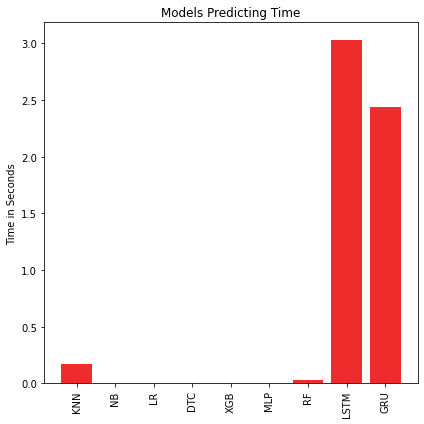

In [135]:
plot_bar_graph(predicting_times, "Models Predicting Time", "Time in Seconds")

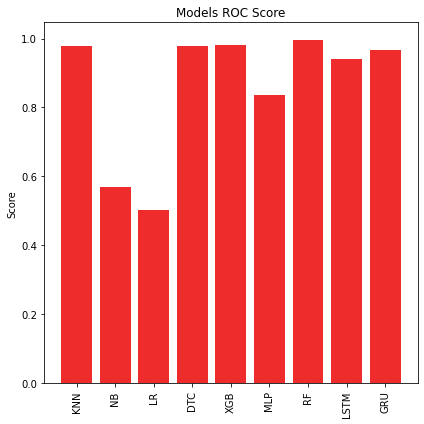

In [136]:
plot_bar_graph(roc_scores, "Models ROC Score", "Score")

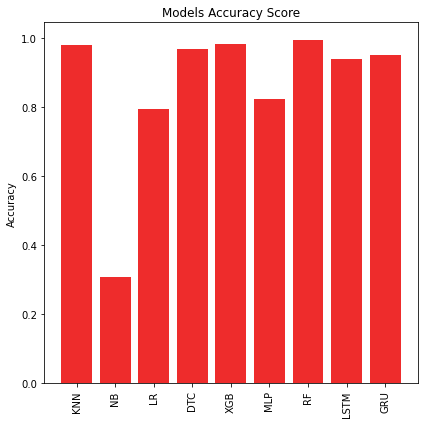

In [137]:
plot_bar_graph(accuracy_scores, "Models Accuracy Score", "Accuracy")

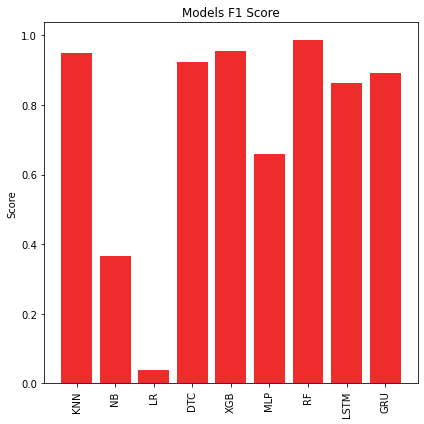

In [138]:
plot_bar_graph(f1_scores, "Models F1 Score", "Score")